## Простой эксперимент

Этот эксперимент простой, потому что не берет во внимание саму структуру бота. Диалоги тут генерируются случайным нормальным распределением.

Здесь я генерирую визиты клиентов в бот с рекламы с заданной продолжительностью.
Поведение каждого клиента симулирую случайным количеством взаимодействий с ботом со случайными промежутками между взаимодействиями.

Так я накапливаю большой массив дат запросов за время работы рекламы.

Полученный массив разбиваю посекундно и считаю, сколько в каждую секунду было сделано запросов от всего объема клиентов.

Если предполагать, что бот отвечает на каждый запрос одним сообщением, то число этих запросов будет равно числу ответов бота.
Так можно оценить, какая будет нагрузка и предполагаемая задержка ответа ботом.

Например, если среднее число запросов в секунду в районе 30, то в среднем бот будет отвечать мгновенно, иногда через секунду, еще реже – через две секунды и т.д.

Но если в боте запрограммированы рассылки в фиксированное время суток, то в эти моменты пиковые нагрузки будут выше, чем оцениваемые в этом эксперименте.

### Вводные данные

In [1]:
import datetime as dt
import pytz

MSK = pytz.timezone('Europe/Moscow')

AD_START_TIME = dt.datetime(2021, 11, 10, 12, tzinfo=MSK)
AD_START_TIME.isoformat()

MIN_CLICKS_PER_HOUR = 800
MAX_CLICKS_PER_HOUR = 1200

AD_TOTAL_DAYS = 5
AD_ACTIVE_HOURS_PER_DAY = 24

EXIT_PROBABILITY = .001

MIN_STEPS = 2
MAX_STEPS = 50
MIN_SECONDS_BETWEEN_STEPS = 5.
MEAN_SECONDS_BETWEEN_STEPS = 60.
STD_SECONDS_BETWEEN_STEPS = 60. * 5


def print_inputs():
    print(
        f'Параметры эксперимента:\n\n'
        f'Старт рекламы: {AD_START_TIME}\n'
        f'Продолжительность рекламы: {AD_TOTAL_DAYS} дней\n'
        f'Реклама активна в течение каждого дня (в часах): {AD_ACTIVE_HOURS_PER_DAY}\n'
        f'Количество кликов по рекламе в час (минимум): {MIN_CLICKS_PER_HOUR}\n'
        f'Количество кликов по рекламе в час (максимум): {MAX_CLICKS_PER_HOUR}\n'
        f'Вероятность, что клиент уйдет (действует на каждом шаге): {EXIT_PROBABILITY:.2%}\n'
        f'Сколько шагов проходит каждый клиент (минимум): {MIN_STEPS}\n'
        f'Сколько шагов проходит каждый клиент (максимум): {MAX_STEPS}\n'
        f'Время между шагами (в секундах, среднее): {MEAN_SECONDS_BETWEEN_STEPS}\n'
        f'Время между шагами (в секундах, стандартное отклонение "шум"): {STD_SECONDS_BETWEEN_STEPS}\n'
    )

print_inputs()

Параметры эксперимента:

Старт рекламы: 2021-11-10 12:00:00+02:30
Продолжительность рекламы: 5 дней
Реклама активна в течение каждого дня (в часах): 24
Количество кликов по рекламе в час (минимум): 800
Количество кликов по рекламе в час (максимум): 1200
Вероятность, что клиент уйдет (действует на каждом шаге): 0.10%
Сколько шагов проходит каждый клиент (минимум): 2
Сколько шагов проходит каждый клиент (максимум): 50
Время между шагами (в секундах, среднее): 60.0
Время между шагами (в секундах, стандартное отклонение "шум"): 300.0



### Симуляция

In [2]:
import pandas as pd
import random
import numpy as np

<AxesSubplot:title={'center':'Распределение времени между шагами (в секундах)'}, ylabel='Frequency'>

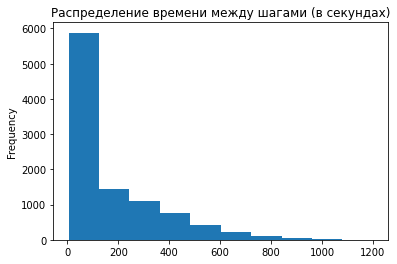

In [3]:
def generate_dialog_steps(count=MAX_STEPS):
    return [
        max(MIN_SECONDS_BETWEEN_STEPS, i) for i in
        np.random.normal(MEAN_SECONDS_BETWEEN_STEPS, STD_SECONDS_BETWEEN_STEPS, count)
    ]

pd.Series(generate_dialog_steps(10000)).plot(kind='hist', bins=10, title='Распределение времени между шагами (в секундах)')

In [4]:
requests = []
total_clients = 0
for day in range(AD_TOTAL_DAYS):
    for hour in range(AD_ACTIVE_HOURS_PER_DAY):
        clicks_in_this_hour = random.uniform(MIN_CLICKS_PER_HOUR, MAX_CLICKS_PER_HOUR)
        start_time = AD_START_TIME + dt.timedelta(days=day, hours=hour)
        for click_no in range(int(clicks_in_this_hour)):
            client_id = f'{day}:{hour}:{click_no}'
            total_clients += 1
            start_time = AD_START_TIME + dt.timedelta(days=day, hours=hour + random.uniform(0, 1))
            request_time = start_time
            steps_count = int(random.uniform(MIN_STEPS, MAX_STEPS))
            for step in generate_dialog_steps(steps_count):
                requests.append({
                    'time': request_time,
                    'client': client_id,
                    'requests': 1,
                })

                request_time += dt.timedelta(seconds=step)
total_requests = len(requests)
f'Сгенерировано запросов: {total_requests}'

'Сгенерировано запросов: 2990216'

In [5]:
requests_df = pd.DataFrame.from_records(requests, index='time')

In [6]:
requests_df.head()

,client,requests
time,,
2021-11-10 13:05:38.439438+03:00,0:0:0,1
2021-11-10 13:06:53.976256+03:00,0:0:0,1
2021-11-10 13:06:58.976256+03:00,0:0:0,1
2021-11-10 13:07:55.432656+03:00,0:0:0,1
2021-11-10 13:09:23.441591+03:00,0:0:0,1


In [7]:
df = requests_df.copy()
df.drop(columns='client', inplace=True)
df.sort_index(inplace=True)
df = df.resample('S').sum()
df.head()

,requests
time,
2021-11-10 12:30:05+03:00,1
2021-11-10 12:30:06+03:00,0
2021-11-10 12:30:07+03:00,1
2021-11-10 12:30:08+03:00,0
2021-11-10 12:30:09+03:00,0


### Результаты

<AxesSubplot:title={'center':'Количество запросов в секунду'}, ylabel='Frequency'>

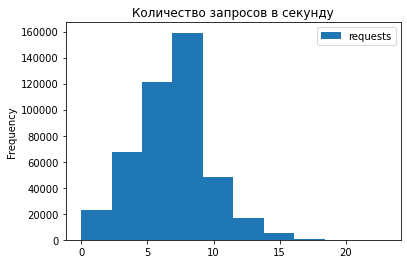

In [8]:
df.plot(kind='hist', title='Количество запросов в секунду', bins=10)

In [9]:
requests_max = df.requests.max()
requests_min = df.requests.min()
requests_mean = df.requests.mean()

def print_results():
    print(
        'Статистика:\n\n'
        'Запросов в секунду:\n'
        f'  Максимум: {requests_max}\n'
        f'  Минимум: {requests_min}\n'
        f'  В среднем: {requests_mean:.2f}\n\n'
        f'Всего клиентов: {total_clients}\n'
        f'Всего взаимодействий: {total_requests}\n'
    )

print_results()

Статистика:

Запросов в секунду:
  Максимум: 23
  Минимум: 0
  В среднем: 6.78

Всего клиентов: 117191
Всего взаимодействий: 2990216



In [10]:
print_inputs()

Параметры эксперимента:

Старт рекламы: 2021-11-10 12:00:00+02:30
Продолжительность рекламы: 5 дней
Реклама активна в течение каждого дня (в часах): 24
Количество кликов по рекламе в час (минимум): 800
Количество кликов по рекламе в час (максимум): 1200
Вероятность, что клиент уйдет (действует на каждом шаге): 0.10%
Сколько шагов проходит каждый клиент (минимум): 2
Сколько шагов проходит каждый клиент (максимум): 50
Время между шагами (в секундах, среднее): 60.0
Время между шагами (в секундах, стандартное отклонение "шум"): 300.0

